In [5]:
N = 3000  # number_of_columns_to_selected_in_termDocumentMatrix
target = 'obscene'

In [6]:
import textmining
import nltk
import string
import numpy as np
from textblob import TextBlob
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.feature_selection import SelectFromModel

In [7]:
data = pd.read_csv("./Dataset/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
sum(data.id.isna())

0

In [9]:
data = data.loc[:, 'id':'identity_hate']
d1 = data.loc[data[target] == 1]
d2 = data.loc[data[target] == 0]
d1.shape
d2.shape[0]
d3 = d1.append(d2[0:d1.shape[0]])
d3.shape
d3.groupby(target).size()
d3 = d3.sort_index()

data = d3.copy()
del([d1,d2,d3])

In [10]:
data.index = range(0, data.shape[0])

In [11]:
id_column = data[['id']]
id_column.shape

(16898, 1)

In [12]:
data.groupby(target).size()

obscene
0    8449
1    8449
dtype: int64

# Pre-processing

In [13]:
stopwd = set(stopwords.words("english"))
punctuations = set(string.punctuation)

In [14]:
def clean(doc):
    stopwd_free = " ".join([i for i in doc.lower().split() if i not in stopwd])
    punc_free = "".join(i for i in stopwd_free if i not in punctuations)
    num_free = "".join(i for i in punc_free if not i.isdigit())
    return num_free

In [15]:
data_corpus = [clean(data.iloc[i,1]) for i in range(0, data.shape[0])]

In [16]:
data['comment_text'] = data_corpus

In [17]:
vectorizer = CountVectorizer(min_df=2, max_features=N)
vec = vectorizer.fit(data['comment_text'])

In [18]:
X = vec.transform(data['comment_text'])
X.shape

(16898, 3000)

In [19]:
train_tdm_all_features = vec.get_feature_names()           # <<=====
len(train_tdm_all_features)

3000

In [20]:
df_tdm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [21]:
df_tdm[target] = data[target]
df_tdm[target] = np.where(df_tdm[target] == 0.0, 0, 1)

In [22]:
df_tdm['id'] = id_column
df_tdm.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero,obscene
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Splitting into train and test data

In [23]:
training_data = df_tdm.sample(n= int(0.8*(df_tdm.shape[0])), random_state=7)
training_data.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero,obscene
15179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
index_of_training_data = training_data.index
index_of_testing_data = [index for index in df_tdm.index if index not in index_of_training_data]
test_data = df_tdm.loc[index_of_testing_data]
test_data.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero,obscene
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_tdm.groupby([target]).size()

obscene
0    8449
1    8449
dtype: int64

In [26]:
training_data.groupby([target]).size()

obscene
0    6770
1    6748
dtype: int64

In [27]:
test_data.groupby([target]).size()

obscene
0    1679
1    1701
dtype: int64

# Creating Model

In [28]:
predictors = [x for x in df_tdm.columns if x not in [target, 'id']]
len(predictors)

2999

In [33]:
xgb_model01 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=200, silent=False, 
                            objective='binary:logistic', n_jobs=-1, gamma=0, min_child_weight=1, 
                            subsample=0.8, colsample_bytree=0.8, seed=5)

In [34]:
xgb_params = xgb_model01.get_xgb_params()
xgtrain = xgb.DMatrix(pd.DataFrame(training_data[predictors]), label=training_data[target].values)
cvresult = xgb.cv(params=xgb_params, dtrain=xgtrain, num_boost_round=xgb_model01.get_params()['n_estimators'], nfold=5, 
                  stratified=False, folds=None, metrics='auc', obj=None, feval=None, 
                  maximize=False, early_stopping_rounds=50, verbose_eval=True)
xgb_model01.set_params(n_estimators=cvresult.shape[0])   

#Fit the xgb_model01 algorithm on the data
xgb_model01.fit(X=training_data[predictors], 
        y=training_data[target], 
        eval_metric='auc')


[0]	train-auc:0.784556+0.00801642	test-auc:0.782034+0.0107969
[1]	train-auc:0.817027+0.0121583	test-auc:0.815266+0.00969174
[2]	train-auc:0.825235+0.0169918	test-auc:0.823084+0.014733
[3]	train-auc:0.849684+0.00664821	test-auc:0.845967+0.0107637
[4]	train-auc:0.853775+0.0060625	test-auc:0.849935+0.0103744
[5]	train-auc:0.858301+0.00694926	test-auc:0.854477+0.0101516
[6]	train-auc:0.86409+0.00714731	test-auc:0.860377+0.0113191
[7]	train-auc:0.867476+0.00441475	test-auc:0.864139+0.00846573
[8]	train-auc:0.875559+0.00486589	test-auc:0.871661+0.00889807
[9]	train-auc:0.882063+0.00383991	test-auc:0.878861+0.00935128
[10]	train-auc:0.886077+0.00372335	test-auc:0.882511+0.00497357
[11]	train-auc:0.892042+0.00521734	test-auc:0.888509+0.00587857
[12]	train-auc:0.895752+0.00529357	test-auc:0.893068+0.00819468
[13]	train-auc:0.900636+0.00498764	test-auc:0.897846+0.00966901
[14]	train-auc:0.903404+0.00480781	test-auc:0.900149+0.00900489
[15]	train-auc:0.90654+0.00314753	test-auc:0.904085+0.0068261

[128]	train-auc:0.976159+0.000132575	test-auc:0.967028+0.00131357
[129]	train-auc:0.976297+0.00015022	test-auc:0.967127+0.00129471
[130]	train-auc:0.976478+0.00028968	test-auc:0.967377+0.00127754
[131]	train-auc:0.97657+0.000297298	test-auc:0.967554+0.00132506
[132]	train-auc:0.97665+0.000295224	test-auc:0.96761+0.00129232
[133]	train-auc:0.976812+0.000256049	test-auc:0.967855+0.00119936
[134]	train-auc:0.977015+0.000309207	test-auc:0.96795+0.00119365
[135]	train-auc:0.977143+0.000286543	test-auc:0.968123+0.00119562
[136]	train-auc:0.977247+0.000258226	test-auc:0.968292+0.00120338
[137]	train-auc:0.977434+0.000240507	test-auc:0.968459+0.00128778
[138]	train-auc:0.977501+0.000211491	test-auc:0.968557+0.00127969
[139]	train-auc:0.977566+0.000237262	test-auc:0.968611+0.00133409
[140]	train-auc:0.977666+0.000258189	test-auc:0.968737+0.00132713
[141]	train-auc:0.977762+0.000287203	test-auc:0.968796+0.00135381
[142]	train-auc:0.97781+0.000269688	test-auc:0.968869+0.00139241
[143]	train-auc:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=5, silent=False, subsample=0.8)

###### Feature Importance Graph

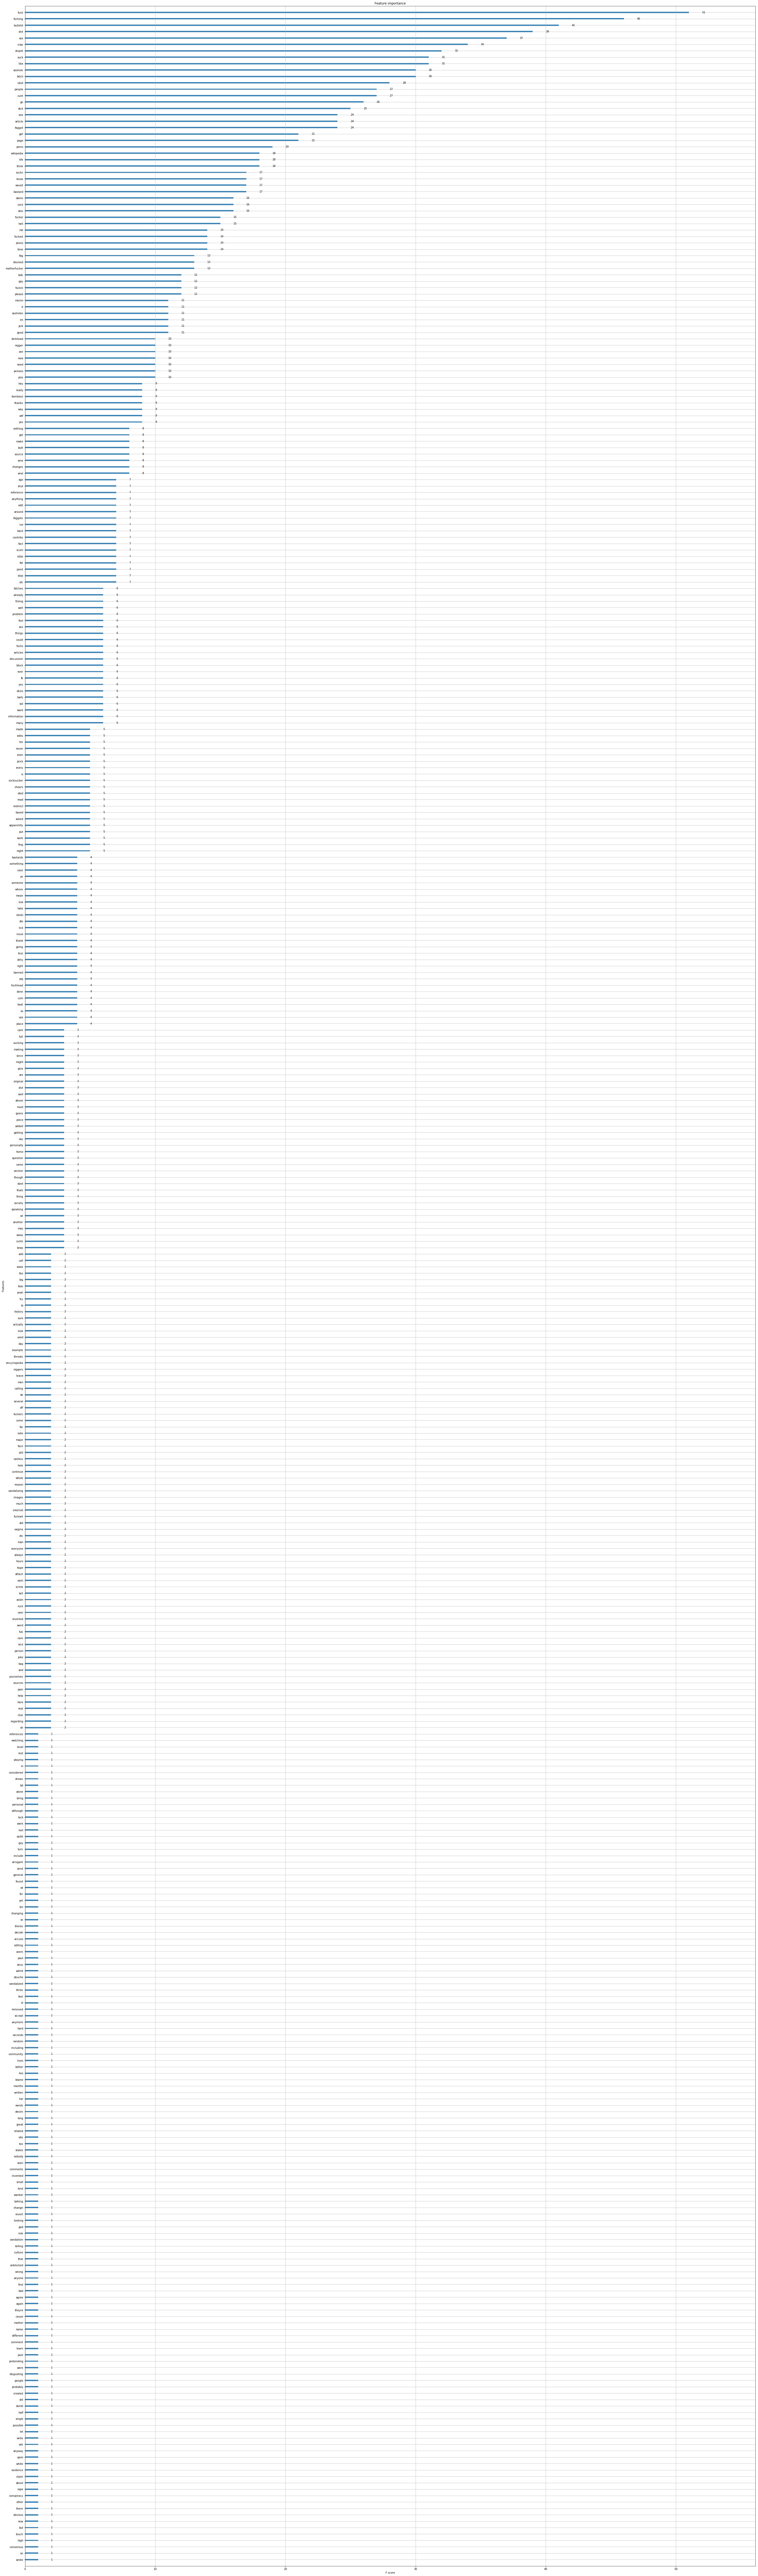

In [35]:
rcParams['figure.figsize'] = 50,180
xgb.plot_importance(xgb_model01.get_booster())

In [36]:
#Predict training set:
train_predictions = xgb_model01.predict(training_data[predictors])
train_predprob = xgb_model01.predict_proba(training_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(training_data[target], train_predictions)) * 100
AUC = float(roc_auc_score(training_data[target], train_predprob, average='weighted')) * 100
f1 = float(f1_score(training_data[target], train_predictions, average='weighted')) * 100

print("\nModel Report (TRAIN) :\n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

# Predicting on test data:
test_predictions = xgb_model01.predict(test_data[predictors])
test_predprob = xgb_model01.predict_proba(test_data[predictors])[:, 1]  

#Print model report:
acc = float(accuracy_score(test_data[target], test_predictions)) * 100
AUC = float(roc_auc_score(test_data[target], test_predprob, average='weighted')) * 100
f1 = float(f1_score(test_data[target], test_predictions, average='weighted')) * 100

print("\nModel Report (TEST) : \n")
print("Accurary : %.6g" % acc)
print("AUC Score : %.6g" % AUC)
print("F1 Score : %.6g" % f1)

C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report (TRAIN) :

Accurary : 92.8318
AUC Score : 98.1726
F1 Score : 92.8101


C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report (TEST) : 

Accurary : 91.3018
AUC Score : 97.2794
F1 Score : 91.2746


# Saving Model

In [66]:
path = './model pickle/'
filename = path + "XGBClassifier_equalData_" + target + "_" + str(N) + "_F1_Score" + str(format(f1, '.6g'))
joblib.dump(xgb_model01, filename)

['./model pickle/XGBClassifier_equalData_obscene_3000_F1_Score91.2746']

# Loading Model

In [32]:
# path = './model pickle/'
# filename = path + 'XGBClassifier_equalData_toxic_3000_F1_Score87.6949'
# xgb_model01 = joblib.load(filename)

# Probability prediction for test.csv provided by kaggle

In [39]:
testCSV = pd.read_csv('./Dataset/test.csv')

In [40]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [41]:
testCSV.shape

(153164, 2)

### Pre-processing

In [42]:
data_corpus_testCSV = [clean(testCSV.iloc[i,1]) for i in range(0, testCSV.shape[0])]

In [43]:
testCSV['comment_text'] = data_corpus_testCSV

In [44]:
testCSV.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine is imo
2,00013b17ad220c46,sources zawe ashton lapland —
3,00017563c3f7919a,if look back source information updated correc...
4,00017695ad8997eb,anonymously edit articles all


In [48]:
vectorizer = CountVectorizer(min_df=2, max_features=N, vocabulary=train_tdm_all_features) 
vec = vectorizer.fit(testCSV['comment_text'])

In [49]:
X = vec.transform(testCSV['comment_text'])
X.shape

(153164, 3000)

In [50]:
df_tdm_testCSV = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

In [51]:
df_tdm_testCSV.id = testCSV.id

In [52]:
predictors_for_testCSV = [x for x in df_tdm_testCSV.columns if x not in [target, 'id']]

In [53]:
df_tdm_testCSV[predictors_for_testCSV].shape

(153164, 2999)

In [55]:
df_tdm_testCSV.head()

,ability,able,about,above,abroad,absolute,absolutely,absurd,abuse,abusing,...,youfuck,young,your,youre,yours,yourself,yourselfgo,yourselves,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
prediction_final = xgb_model01.predict_proba((df_tdm_testCSV[predictors_for_testCSV]))[:,1]

In [60]:
final_submission = pd.read_csv('./sample_submission.csv')

In [61]:
final_submission.head()

,Unnamed: 0,id,toxic
0,0,00001cee341fdb12,0.999996
1,1,0000247867823ef7,0.166511
2,2,00013b17ad220c46,0.266785
3,3,00017563c3f7919a,0.071220
4,4,00017695ad8997eb,0.327090


In [63]:
final_submission[target] = prediction_final

In [64]:
final_submission.head()

,Unnamed: 0,id,toxic,obscene
0,0,00001cee341fdb12,0.999996,0.998782
1,1,0000247867823ef7,0.166511,0.245466
2,2,00013b17ad220c46,0.266785,0.213822
3,3,00017563c3f7919a,0.071220,0.091228
4,4,00017695ad8997eb,0.327090,0.182571


###### Saving csv file on the disk

In [65]:
final_submission.to_csv('./sample_submission.csv')